# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

#¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



In [1]:
import numpy as np
import pandas as pd
import pylab as plt
from google.colab import drive
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [2]:
## Importo los modelos que voy a probar:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

## Librerías de optimización de modelos:
from sklearn.model_selection import RandomizedSearchCV


Carga de datos. Lo hago desde el drive.

In [3]:
# Vincular la cuenta de Googgle Drive donde están almacenados los archivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
datos=pd.read_csv('/content/drive/MyDrive/covid-data.csv')
datos

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201955,ZWE,Africa,Zimbabwe,2022-07-13,255981.0,0.0,25.143,5565.0,0.0,0.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
201956,ZWE,Africa,Zimbabwe,2022-07-14,256047.0,66.0,34.571,5566.0,1.0,0.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
201957,ZWE,Africa,Zimbabwe,2022-07-15,256083.0,36.0,27.429,5566.0,0.0,0.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
201958,ZWE,Africa,Zimbabwe,2022-07-16,256083.0,0.0,22.714,5566.0,0.0,0.429,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


**ANÁLISIS EXPLORATORIO DE DATOS:**

In [5]:
#Veo el tamaño del dataset (numero de filas y columnas)
print("Tamaño del dataset - filas, columnas:", datos.shape)

Tamaño del dataset - filas, columnas: (201960, 67)


In [6]:
#Nombres de cada columna del dataset
print("Nombre de las columnas del dataset:", datos.columns)

Nombre de las columnas del dataset: Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'n

In [7]:
#Veo los paises que aparecen en el dataset:
print("Los paises publicados son:\n", datos["location"].value_counts())


Los paises publicados son:
 Argentina          929
Mexico             929
Thailand           926
Taiwan             914
South Korea        909
                  ... 
Northern Cyprus    317
Niue               266
Tokelau            114
Pitcairn            85
Western Sahara       1
Name: location, Length: 244, dtype: int64


In [8]:
datos_covid = (datos.loc[:,['location','iso_code','date','total_tests',"total_deaths","total_cases","new_cases"]])
datos_covid.head()

,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
0,Afghanistan,AFG,2020-02-24,NaN,NaN,5.0,5.0
1,Afghanistan,AFG,2020-02-25,NaN,NaN,5.0,0.0
2,Afghanistan,AFG,2020-02-26,NaN,NaN,5.0,0.0
3,Afghanistan,AFG,2020-02-27,NaN,NaN,5.0,0.0
4,Afghanistan,AFG,2020-02-28,NaN,NaN,5.0,0.0


In [9]:
datos_covid.isnull().sum()

location             0
iso_code             0
date                 0
total_tests     122575
total_deaths     26755
total_cases       8069
new_cases         8418
dtype: int64

In [10]:
datos_covid.columns

Index(['location', 'iso_code', 'date', 'total_tests', 'total_deaths',
       'total_cases', 'new_cases'],
      dtype='object')

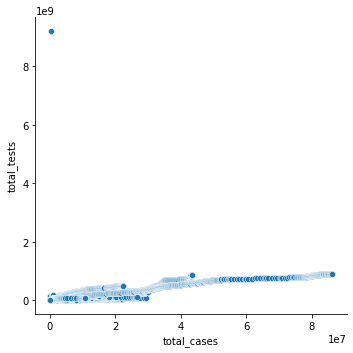

In [11]:
sns.relplot(x = "total_cases", y="total_tests", data=datos_covid)

In [12]:
#Creo un DF con cada pais elegido cuyas instancias correspondientes a la variable 'total_cases' sean valores mayores a 0

maskCovidArgentina=datos_covid[((datos_covid.location == "Argentina")) & ((datos_covid.total_cases >= 1))] 
Argentina=pd.DataFrame(maskCovidArgentina)
Argentina.head()


,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
6988,Argentina,ARG,2020-03-03,704.0,NaN,1.0,1.0
6989,Argentina,ARG,2020-03-04,710.0,NaN,1.0,0.0
6990,Argentina,ARG,2020-03-05,717.0,NaN,1.0,0.0
6991,Argentina,ARG,2020-03-06,729.0,NaN,2.0,1.0
6992,Argentina,ARG,2020-03-07,738.0,NaN,8.0,6.0


In [13]:
#DF todos los datos de Argentina
maskCovidArgentina2=datos_covid[((datos_covid.location == "Argentina"))] 
Argentina2=pd.DataFrame(maskCovidArgentina2)
Argentina2.head()

,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
6926,Argentina,ARG,2020-01-01,4.0,NaN,NaN,NaN
6927,Argentina,ARG,2020-01-02,99.0,NaN,NaN,NaN
6928,Argentina,ARG,2020-01-03,104.0,NaN,NaN,NaN
6929,Argentina,ARG,2020-01-04,180.0,NaN,NaN,NaN
6930,Argentina,ARG,2020-01-05,194.0,NaN,NaN,NaN


In [14]:
Argentina2.iloc[500:550]
Argentina2.tail()

,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
7850,Argentina,ARG,2022-07-13,NaN,129145.0,9426171.0,0.0
7851,Argentina,ARG,2022-07-14,NaN,129145.0,9426171.0,0.0
7852,Argentina,ARG,2022-07-15,NaN,129145.0,9426171.0,0.0
7853,Argentina,ARG,2022-07-16,NaN,129145.0,9426171.0,0.0
7854,Argentina,ARG,2022-07-17,NaN,129202.0,9465827.0,39656.0


Elimino los NaN de la columna total_cases (acumulado de casos) para agilizar el código. De esta manera empieza a contabilizar desde el primer caso detectado.

In [15]:
datos_covid = datos_covid.dropna(subset=["total_cases"]) #quito los NaN de la columna total_cases
print()
datos_covid.head()

,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
0,Afghanistan,AFG,2020-02-24,NaN,NaN,5.0,5.0
1,Afghanistan,AFG,2020-02-25,NaN,NaN,5.0,0.0
2,Afghanistan,AFG,2020-02-26,NaN,NaN,5.0,0.0
3,Afghanistan,AFG,2020-02-27,NaN,NaN,5.0,0.0
4,Afghanistan,AFG,2020-02-28,NaN,NaN,5.0,0.0


In [16]:
datos_covid.isnull().sum()

location             0
iso_code             0
date                 0
total_tests     117919
total_deaths     18687
total_cases          0
new_cases          356
dtype: int64

Reindexamos:

In [17]:
datos_covid.reset_index(inplace=True, drop=False) #pongo el indice en órden tal que pueda usar todos los datos en una funcion sin repetir
datos_covid.head()

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
0,0,Afghanistan,AFG,2020-02-24,NaN,NaN,5.0,5.0
1,1,Afghanistan,AFG,2020-02-25,NaN,NaN,5.0,0.0
2,2,Afghanistan,AFG,2020-02-26,NaN,NaN,5.0,0.0
3,3,Afghanistan,AFG,2020-02-27,NaN,NaN,5.0,0.0
4,4,Afghanistan,AFG,2020-02-28,NaN,NaN,5.0,0.0


In [18]:
paises=datos_covid['location'] #cargo el vector de paises
confirmados=datos_covid['total_cases'] #carga vector todos los casos 
casosnuevos = datos_covid['new_cases'] #vector de casos nuevos

**CHINA:**

Text(0, 0.5, 'cantidad de casos')

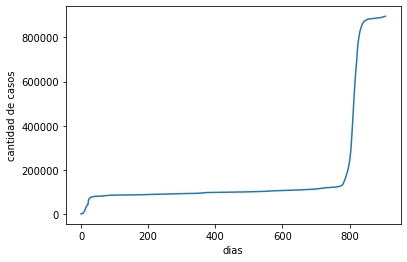

In [19]:
#Sabemos el la pandemia comenzó en Wuhan, China
#Curva de casos (acumulado)
ind_China=np.where(paises=='China')
ind_China=ind_China[0]
casos_China=confirmados[ind_China]
dias=np.arange(0,len(casos_China))
plt.plot(dias,casos_China)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'cantidad de casos nuevos por día')

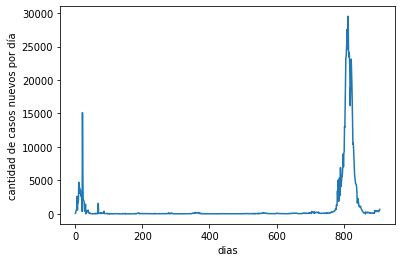

In [20]:
#Curva de casos nuevos diarios
casos_nuevos_China = casosnuevos[ind_China]
dias=np.arange(0,len(casos_China))
plt.plot(dias,casos_nuevos_China)
plt.xlabel('dias')
plt.ylabel('cantidad de casos nuevos por día')

Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad.

Los datos de casos confirmados en función del tiempo C(t), pueden aproximarse con el modelo

C
(
t
)
=
e
k
(
t
−
t
0
)

donde t0 es la fecha del primer contagio, y k es un parámetro propio de cada enfermedad, que habla de la contagiosidad.

In [21]:
#es necesario conocer la curva exponencial de crecimiento de los primeros días de la pandemia
#se genera la funcion. 

def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [22]:
#tomamos los primeros 60 días, desde el primer caso detectado
casos_principio_China=casos_China[0:60]
dias_principio_China=dias[0:60]

In [23]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio_China, casos_principio_China) 
popt, pcov
# curve_fit devuelve dos resultados: El primero (popt) son los parámetros óptimos hallados. 
#El segundo (pcov) es la matriz de covarianza de los parámetros hallados

(array([ 2.27414801e-02, -4.48780638e+02]),
 array([[6.49493467e-06, 1.40101275e-01],
        [1.40101275e-01, 3.02479575e+03]]))

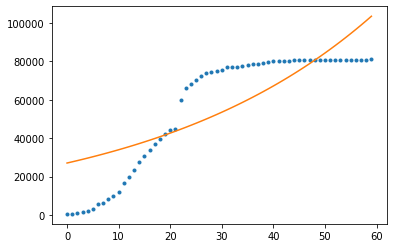

In [24]:
k_China=popt[0]
t0_China=popt[1]
casos_simu_China=exponencial(dias_principio_China,k_China,t0_China)
plt.plot(dias_principio_China,casos_principio_China,'.')
plt.plot(dias_principio_China,casos_simu_China)

In [25]:
k_China

0.02274148006994921

**ARGENTINA:**

Text(0, 0.5, 'cantidad de casos')

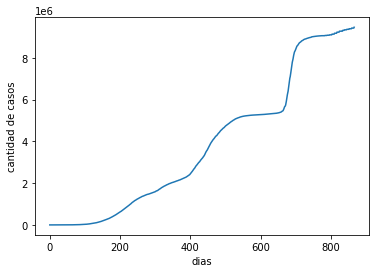

In [26]:
#Tomamos los datos de Argentina
ind_arg=np.where(paises=='Argentina')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias=np.arange(0,len(casos_arg))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de casos totales de la Argentina. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Text(0, 0.5, 'cantidad de casos nuevos por día')

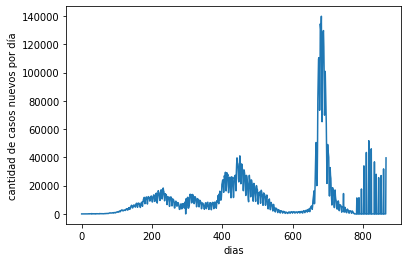

In [27]:
#Nuevos casos en Argentina
casos_nuevos_Arg = casosnuevos[ind_arg]
plt.plot(dias,casos_nuevos_Arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos nuevos por día')

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica

In [28]:
dias.size, casos_arg.size

(867, 867)

Text(0, 0.5, 'log cantidad de casos')

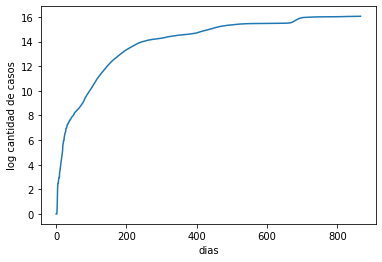

In [29]:
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el 
k
 inicial

In [30]:
groupby = datos_covid.groupby([datos_covid[datos_covid.location== "Argentina"].location, "date"])["total_cases"].count()
groupby.head()

location   date      
Argentina  2020-03-03    1
           2020-03-04    1
           2020-03-05    1
           2020-03-06    1
           2020-03-07    1
Name: total_cases, dtype: int64

In [31]:
Argentina = datos_covid[datos_covid.location.isin(["Argentina"])]
Argentina.head() #datos de Arg
Argentina_2 = Argentina[Argentina.total_cases.isin([1])]
Argentina_2.head() #para saber cuándo es el primer caso de covid en el pais

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
6912,6988,Argentina,ARG,2020-03-03,704.0,NaN,1.0,1.0
6913,6989,Argentina,ARG,2020-03-04,710.0,NaN,1.0,0.0
6914,6990,Argentina,ARG,2020-03-05,717.0,NaN,1.0,0.0


Text(0, 0.5, 'cantidad de casos')

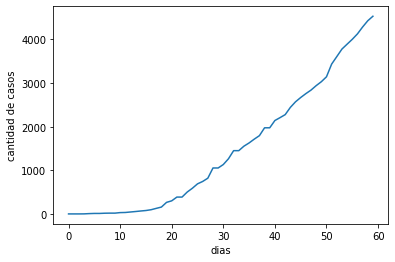

In [32]:
#tomamos el primera tramo - 60 días - desde el primer detectado
casos_principio=casos_arg[0:60]#[62:122] #desde el 0 a 60 no hubo casos registrados en argentina, se toma como iicio el primer día que se registró un caso (día 62)
#como se eliminaron los NaN de la columna, y se reindexó, no hace falta.
dias_principio=dias[0:60]#[62:122]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

Text(0, 0.5, 'log cantidad de casos')

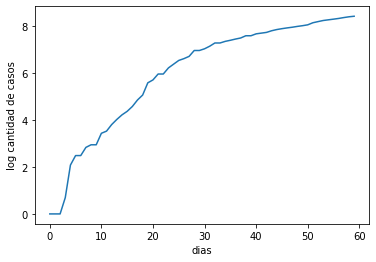

In [33]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

#en el gráfico se ve que la curva exponencial inicia en el día 62

Me quedo con lo que ocurrio entre los días 31 y 55 a partir de la aparición del primer caso, ya que ese fue el comportamiento más sostenido.


Text(0, 0.5, 'cantidad de casos')

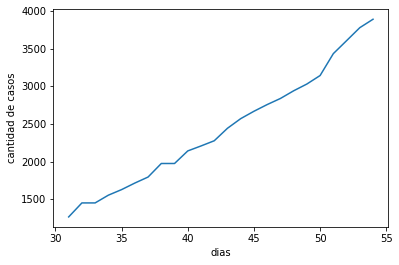

In [34]:
casos_principio_arg=casos_arg[31:55] #idem anterior, el día 31 desde el primer registro es el día 93 del total del inicio del registro general
dias_principio_arg=dias[31:55]

plt.plot(dias_principio_arg,casos_principio_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Se ve bastante lineal. Aprovecho esto para averiguar el 
k
 utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo.

In [35]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [36]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio_arg, casos_principio_arg) 
popt, pcov
# curve_fit devuelve dos resultados: El primero (popt) son los parámetros óptimos hallados. 
#El segundo (pcov) es la matriz de covarianza de los parámetros hallados.

(array([ 4.53529440e-02, -1.28406655e+02]),
 array([[5.72305618e-07, 2.20760596e-03],
        [2.20760596e-03, 8.52627441e+00]]))

Como ajusta con datos reales:

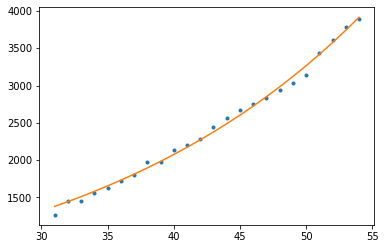

In [37]:
k_arg=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio_arg,k_arg,t0)
plt.plot(dias_principio_arg,casos_principio_arg,'.')
plt.plot(dias_principio_arg,casos_simu)

In [38]:
k_arg

0.04535294398082471

**Elijo 5 paises del hemosferio Norte y calculo el k de cada uno:**

CANADA:

In [39]:
canada = datos_covid[datos_covid.location.isin(["Canada"])]
canada.head() #datos de Canadá
Canada2 = canada[canada.total_cases.isin([1])]
Canada2.head() #para saber cuándo es el primer caso de covid en Canada

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases


Text(0, 0.5, 'cantidad de casos')

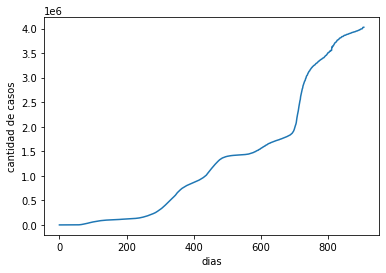

In [40]:
#Curva de casos totales
ind_Canada=np.where(paises=='Canada')
ind_Canada=ind_Canada[0]
casos_Canada=confirmados[ind_Canada]
casos_nuevos_Canada = casosnuevos[ind_Canada]
dias=np.arange(0,len(casos_Canada))
plt.plot(dias,casos_Canada)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'cantidad de casos nuevos por día')

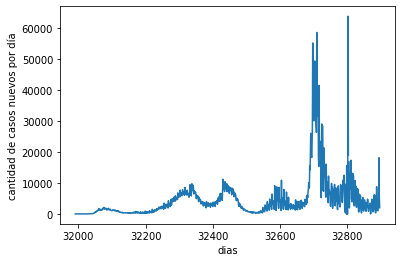

In [41]:
#curva de casos nuevos
casos_Canada=np.array(casos_Canada)
nuevos_Canada=casos_nuevos_Canada #funcion
plt.plot(nuevos_Canada)
plt.xlabel('dias')
plt.ylabel('cantidad de casos nuevos por día')


Text(0, 0.5, 'log cantidad de casos')

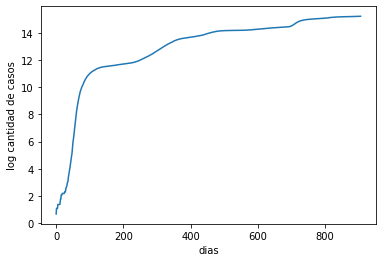

In [42]:
#Escala logaritmica
plt.plot(dias,np.log(casos_Canada))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

In [43]:
casos_principio_Canada=casos_Canada[00:60]
dias_principio_Canada=dias[00:60]


Text(0, 0.5, 'cantidad de casos')

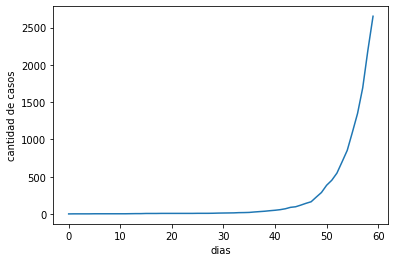

In [44]:
plt.plot(dias_principio_Canada,casos_principio_Canada)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

In [45]:
#ajustamos
popt_Canada, pcov_Canada = curve_fit(exponencial, dias_principio_Canada, casos_principio_Canada) 
print(popt_Canada)
print(pcov_Canada)

[ 0.22306184 23.62598624]
[[1.64177649e-06 2.47268661e-04]
 [2.47268661e-04 3.74043045e-02]]


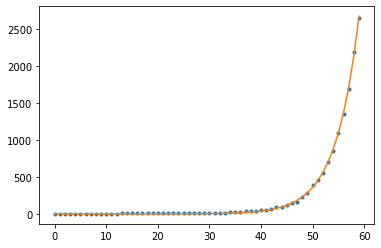

In [46]:
k_Canada=popt_Canada[0]
t0_Canada=popt_Canada[1]
casos_simu_Canada=exponencial(dias_principio_Canada,k_Canada,t0_Canada)
plt.plot(dias_principio_Canada,casos_principio_Canada,'.')
plt.plot(dias_principio_Canada,casos_simu_Canada)

In [47]:
k_Canada

0.2230618424973766

ITALIA:

In [48]:
Italia = datos_covid[datos_covid.location.isin(["Italy"])]
Italia.head() #datos de Canadá
Italia2 = Italia[Italia.total_cases.isin([1])]
Italia2.head() #para saber cuándo es el primer caso de covid en ese pais

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases


Text(0, 0.5, 'cantidad de casos')

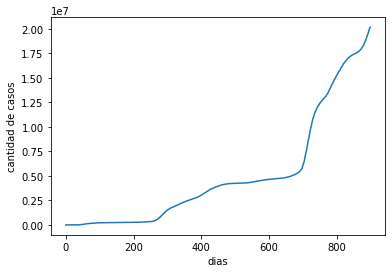

In [49]:
ind_Italia=np.where(paises=='Italy')
ind_Italia=ind_Italia[0]
casos_Italia=confirmados[ind_Italia]
casos_nuevos_Italia = casosnuevos[ind_Italia]
dias=np.arange(0,len(casos_Italia))
plt.plot(dias,casos_Italia)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')


In [50]:
casos_principio_Italia=casos_Italia[0:60]
dias_principio_Italia=dias[0:60]

In [51]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio_Italia, casos_principio_Italia) 
popt, pcov

(array([  0.10163528, -55.61073692]), array([[9.40795754e-06, 1.01979562e-02],
        [1.01979562e-02, 1.10762401e+01]]))

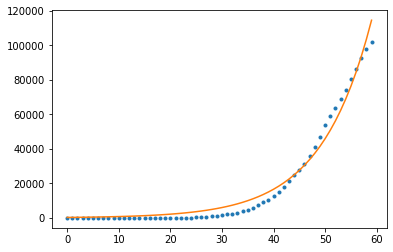

In [52]:
k_Italia=popt[0]
t0_Italia=popt[1]
casos_simu_Italia=exponencial(dias_principio_Italia,k_Italia,t0_Italia)
plt.plot(dias_principio_Italia,casos_principio_Italia,'.')
plt.plot(dias_principio_Italia,casos_simu_Italia)

In [53]:
k_Italia

0.10163528334715499

ALEMANIA:

In [54]:
Alemania = datos_covid[datos_covid.location.isin(["Germany"])]
Alemania.head() #datos del pais

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
67890,68095,Germany,DEU,2020-01-27,NaN,NaN,1.0,1.0
67891,68096,Germany,DEU,2020-01-28,NaN,NaN,4.0,3.0
67892,68097,Germany,DEU,2020-01-29,NaN,NaN,4.0,0.0
67893,68098,Germany,DEU,2020-01-30,NaN,NaN,4.0,0.0
67894,68099,Germany,DEU,2020-01-31,NaN,NaN,5.0,1.0


Text(0, 0.5, 'cantidad de casos')

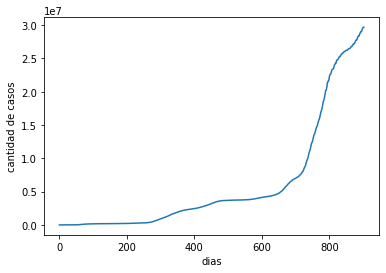

In [55]:
#curva exponencial del curso de la infeccion, casos totales
ind_Alemania=np.where(paises=='Germany')
ind_Alemania=ind_Alemania[0]
casos_Alemania=confirmados[ind_Alemania]
casos_nuevos_Alemania = casosnuevos[ind_Alemania]
dias=np.arange(0,len(casos_Alemania))
plt.plot(dias,casos_Alemania)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'cantidad de casos nuevos por día')

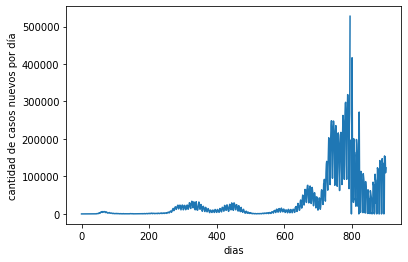

In [56]:
plt.plot(dias,casos_nuevos_Alemania)
plt.xlabel('dias')
plt.ylabel('cantidad de casos nuevos por día')



In [57]:
casos_principio_Alemania=casos_Alemania[0:60]
dias_principio_Alemania=dias[0:60]

In [58]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio_Alemania, casos_principio_Alemania) 
popt, pcov

(array([0.18142066, 0.87829894]), array([[5.98794385e-06, 1.84291931e-03],
        [1.84291931e-03, 5.68565163e-01]]))

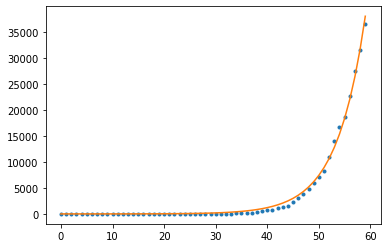

In [59]:
k_Alemania=popt[0]
t0_Alemania=popt[1]
casos_simu_Alemania=exponencial(dias_principio_Alemania,k_Alemania,t0_Alemania)
plt.plot(dias_principio_Alemania,casos_principio_Alemania,'.')
plt.plot(dias_principio_Alemania,casos_simu_Alemania)

In [60]:
k_Alemania

0.18142066208040417

ESTADOS UNIDOS:

In [61]:
EEUU = datos_covid[datos_covid.location.isin(["United States"])]
EEUU.head() #datos del pais

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
183045,190295,United States,USA,2020-01-22,NaN,NaN,1.0,NaN
183046,190296,United States,USA,2020-01-23,NaN,NaN,1.0,0.0
183047,190297,United States,USA,2020-01-24,NaN,NaN,2.0,1.0
183048,190298,United States,USA,2020-01-25,NaN,NaN,2.0,0.0
183049,190299,United States,USA,2020-01-26,NaN,NaN,5.0,3.0


Text(0, 0.5, 'cantidad de casos')

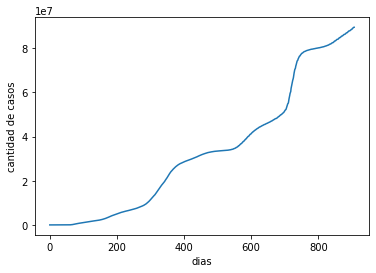

In [62]:
ind_EEUU=np.where(paises=='United States')
ind_EEUU=ind_EEUU[0]
casos_EEUU=confirmados[ind_EEUU]
casos_nuevos_EEUU = casosnuevos[ind_EEUU]
dias=np.arange(0,len(casos_EEUU))
plt.plot(dias,casos_EEUU)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'cantidad de casos nuevos por día')

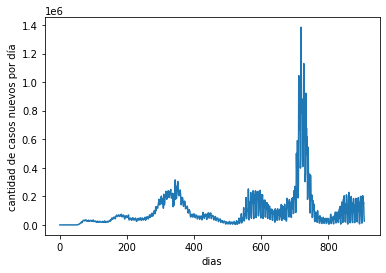

In [63]:
plt.plot(dias,casos_nuevos_EEUU)
plt.xlabel('dias')
plt.ylabel('cantidad de casos nuevos por día')

In [64]:
casos_principio_EEUU=casos_EEUU[0:60]
dias_principio_EEUU=dias[0:60]

In [65]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio_EEUU, casos_principio_EEUU) 
popt, pcov

(array([ 0.33414979, 28.52034216]), array([[1.45671738e-05, 1.28290731e-03],
        [1.28290731e-03, 1.13265040e-01]]))

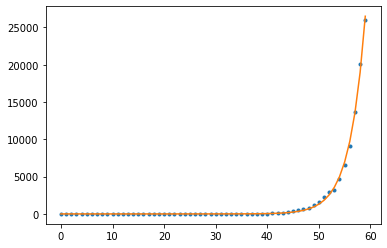

In [66]:
k_EEUU=popt[0]
t0_EEUU=popt[1]
casos_simu_EEUU=exponencial(dias_principio_EEUU,k_EEUU,t0_EEUU)
plt.plot(dias_principio_EEUU,casos_principio_EEUU,'.')
plt.plot(dias_principio_EEUU,casos_simu_EEUU)

In [67]:
k_EEUU

0.3341497918547016

INGLATERRA:

In [68]:
UK = datos_covid[datos_covid.location.isin(["United Kingdom"])]
UK.head() #datos del pais

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
182146,189396,United Kingdom,GBR,2020-01-31,NaN,NaN,2.0,2.0
182147,189397,United Kingdom,GBR,2020-02-01,NaN,NaN,2.0,0.0
182148,189398,United Kingdom,GBR,2020-02-02,NaN,NaN,2.0,0.0
182149,189399,United Kingdom,GBR,2020-02-03,NaN,NaN,8.0,6.0
182150,189400,United Kingdom,GBR,2020-02-04,NaN,NaN,8.0,0.0


Text(0, 0.5, 'cantidad de casos')

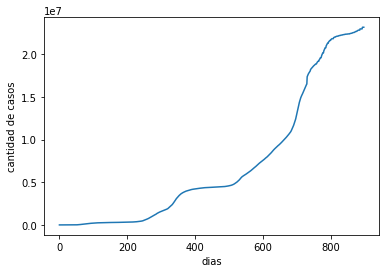

In [69]:
#curva exponencial del curso de la infeccion, casos totales
ind_UK=np.where(paises=='United Kingdom')
ind_UK=ind_UK[0]
casos_UK=confirmados[ind_UK]
casos_nuevos_UK = casosnuevos[ind_UK]
dias=np.arange(0,len(casos_UK))
plt.plot(dias,casos_UK)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'cantidad de casos nuevos por día UK')

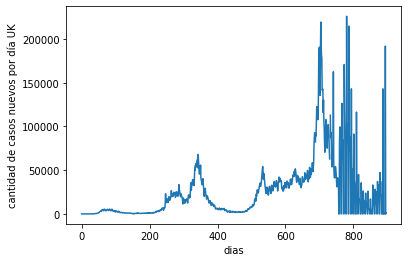

In [70]:
plt.plot(dias,casos_nuevos_UK)
plt.xlabel('dias')
plt.ylabel('cantidad de casos nuevos por día UK')

In [71]:
casos_principio_UK=casos_UK[0:60]
dias_principio_UK=dias[0:60]

In [72]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio_UK, casos_principio_UK) 
popt, pcov

(array([ 0.15213423, -9.90779803]), array([[5.30911984e-06, 2.30654565e-03],
        [2.30654565e-03, 1.00453673e+00]]))

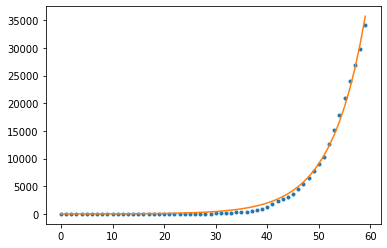

In [73]:
k_UK=popt[0]
t0_UK=popt[1]
casos_simu_UK=exponencial(dias_principio_UK,k_UK,t0_UK)
plt.plot(dias_principio_UK,casos_principio_UK,'.')
plt.plot(dias_principio_UK,casos_simu_UK)

In [74]:
k_UK

0.15213423221593736

PAISES BAJOS:

In [75]:
PB = datos_covid[datos_covid.location.isin(["Netherlands"])]
PB.head()

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
124929,127776,Netherlands,NLD,2020-02-27,NaN,NaN,1.0,1.0
124930,127777,Netherlands,NLD,2020-02-28,NaN,NaN,6.0,5.0
124931,127778,Netherlands,NLD,2020-02-29,NaN,NaN,10.0,4.0
124932,127779,Netherlands,NLD,2020-03-01,NaN,NaN,18.0,8.0
124933,127780,Netherlands,NLD,2020-03-02,NaN,NaN,24.0,6.0


Text(0, 0.5, 'cantidad de casos')

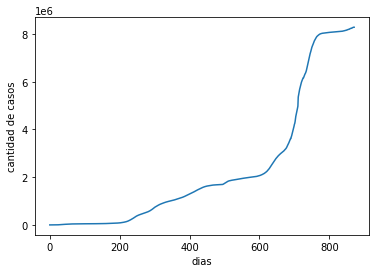

In [76]:
#curva exponencial del curso de la infeccion, casos totales
ind_PB=np.where(paises=='Netherlands')
ind_PB=ind_PB[0]
casos_PB=confirmados[ind_PB]
casos_nuevos_PB = casosnuevos[ind_PB]
dias=np.arange(0,len(casos_PB))
plt.plot(dias,casos_PB)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'cantidad de casos nuevos por día PB')

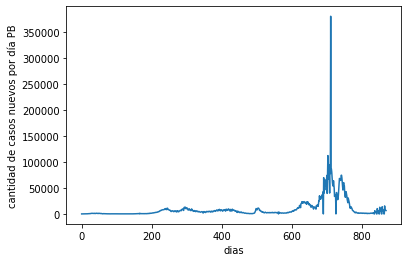

In [77]:
plt.plot(dias,casos_nuevos_PB)
plt.xlabel('dias')
plt.ylabel('cantidad de casos nuevos por día PB')

In [78]:
casos_principio_PB=casos_PB[0:60]
dias_principio_PB=dias[0:60]

In [79]:
#ajustamos a la funcion
popt, pcov = curve_fit(exponencial, dias_principio_PB, casos_principio_PB) 
popt, pcov

(array([ 5.08557437e-02, -1.51920906e+02]),
 array([[5.52271279e-06, 2.19049025e-02],
        [2.19049025e-02, 8.70710289e+01]]))

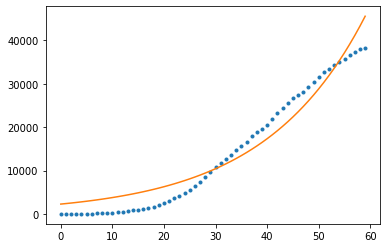

In [80]:
k_PB=popt[0]
t0_PB=popt[1]
casos_simu_PB=exponencial(dias_principio_PB,k_PB,t0_PB)
plt.plot(dias_principio_PB,casos_principio_PB,'.')
plt.plot(dias_principio_PB,casos_simu_PB)

In [81]:
k_PB

0.05085574373963367

PORTUGAL:

In [82]:
Portugal = datos_covid[datos_covid.location.isin(["Portugal"])]
Portugal.head()

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
141864,146723,Portugal,PRT,2020-03-02,70.0,NaN,2.0,2.0
141865,146724,Portugal,PRT,2020-03-03,131.0,NaN,2.0,0.0
141866,146725,Portugal,PRT,2020-03-04,171.0,NaN,5.0,3.0
141867,146726,Portugal,PRT,2020-03-05,251.0,NaN,8.0,3.0
141868,146727,Portugal,PRT,2020-03-06,332.0,NaN,13.0,5.0


Text(0, 0.5, 'cantidad de casos')

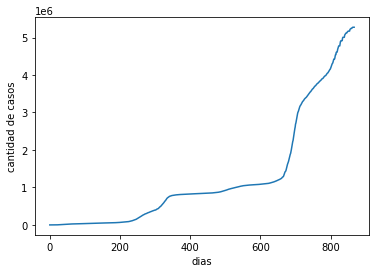

In [83]:
#curva exponencial del curso de la infeccion, casos totales
ind_Portugal=np.where(paises=='Portugal')
ind_Portugal=ind_Portugal[0]
casos_Portugal=confirmados[ind_Portugal]
casos_nuevos_Portugal = casosnuevos[ind_Portugal]
dias=np.arange(0,len(casos_Portugal))
plt.plot(dias,casos_Portugal)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'cantidad de casos nuevos por día - Portugal')

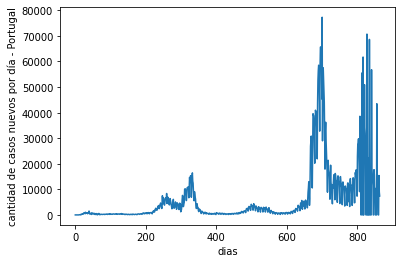

In [84]:
plt.plot(dias,casos_nuevos_Portugal)
plt.xlabel('dias')
plt.ylabel('cantidad de casos nuevos por día - Portugal')

In [85]:
casos_principio_Portugal=casos_Portugal[0:60] 
dias_principio_Portugal=dias[0:60]

In [86]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio_Portugal, casos_principio_Portugal) 
popt, pcov

(array([ 4.76187460e-02, -1.57685264e+02]),
 array([[7.13384641e-06, 3.09914093e-02],
        [3.09914093e-02, 1.34944256e+02]]))

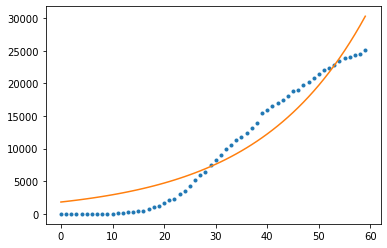

In [87]:
k_Portugal=popt[0]
t0_Portugal=popt[1]
casos_simu_Portugal=exponencial(dias_principio_Portugal,k_Portugal,t0_Portugal)
plt.plot(dias_principio_Portugal,casos_principio_Portugal,'.')
plt.plot(dias_principio_Portugal,casos_simu_Portugal)

In [88]:
k_Portugal

0.047618746019875015

In [89]:
ind_World=np.where(paises=='World')
ind_World=ind_World[0]
casos_World=confirmados[ind_World]
casos_nuevos_World = casosnuevos[ind_World]
dias=np.arange(0,len(casos_World))

In [90]:
casos_principio_World=casos_World[0:60] 
dias_principio_World=dias[0:60]

In [91]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio_World, casos_principio_World) 

k_World=popt[0]
t0_World=popt[1]
casos_simu_World=exponencial(casos_principio_World,k_World,t0_World)

k_World

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.05047950574784028

Los métodos estadísticos basados en muestreo repetido (resampling) se engloban dentro de la estadística no paramétrica, ya que no requieren de ninguna asunción sobre la distribución de las poblaciones estudiadas. Son, por lo tanto, una alternativa a los test paramétricos (t-test, anova,…) cuando no se satisfacen sus condiciones o cuando se quiere hacer inferencia sobre un parámetro distinto a la media. Uno de los métodos de resampling más utilizados: el bootstrapping. La estrategia de bootstrapping se puede emplear para resolver varios problemas:

Calcular intervalos de confianza de un parámetro poblacional.

Calcular la significancia estadística (p-value) de la diferencia entre poblaciones.

Calcular intervalos de confianza para la diferencia entre poblaciones.

El valor K que mide la diferencia de a cuánta gente contagia una persona infectada. Es decir, K es el valor estadístico que nos dice cuánta variación hay en esta distribución.

Por regla general, cuanto más bajo es el número K, menos son los que están transmitiendo la enfermedad a otros.

Analizar si es posible estimar la evolución mundial de la pandemia a partir de lo obtenido. Para esto será necesario elaborar un intervalo de confianza para k a partir de los obtenidos y generar un modelo nuevo, basado en la distribución de k.

Luego comparar el modelo con los datos mundiales.

In [92]:
from numpy import array

In [93]:
Paises_Norte_K = array([k_Alemania, k_Portugal, k_Canada, k_EEUU, k_Italia, k_PB, k_UK])
Paises_Norte_K

array([0.18142066, 0.04761875, 0.22306184, 0.33414979, 0.10163528,
       0.05085574, 0.15213423])

In [94]:
#Se crea la funcion 
#Función para calcular el estadístico de interés.    
    #Parametros:
    #x : numpy array: valores de la muestra.
    #Returns: estadístico (media)    
def calcular_estadistico(x):
    estadistico = np.mean(x)
    return(estadistico)

In [95]:
'''
    Función para calcular el valor del estadístico en múltiples muestras generadas mediante bootstrapping.
    Parametros
    x : numpy array: muestra.
    fun_estadistico : funcion que recibe como argumento una muestra y devuelve el valor del estadístico. En este caso se va a usar 'calcular_estadistico', ya creada.
    n_iteraciones : Número iteraciones
        
    Returns:
    distribuciones: numpy array con valor del estadístico en cada muestra de bootstrapping.
    '''
def bootstraping(x, fun_estadistico, n_iteraciones=9999): #N_iteraciones = 9999, significa que tomara ese valor como default
    n = len(x) #cada n tiene que ser del mismo tamaño que la muestra experimental; entonces n tiene el tamaño de x
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan) #un array del tamaño de n_iteraciones
    #np.full = crear un array con el tamaño que le pase (shape = n_iteraciones) y de entrada cada posiciíon es un nan (se llena despues, con el for loop)
        
    for i in range(n_iteraciones): #esto es: voy a tomar tantas muestras como n_iteraciones. Por cada iteracion en el rango de iteraciones
        resample = np.random.choice(x, size=n, replace=True) #Crea una muestra (resample). Usa random.choice, sobre x (mis datos), le pasa el tamaño de n, con reemplazo
        dist_boot[i] = fun_estadistico(resample) #a cada resample (a cada iteracion) aplica la funcion_estadistico a cada resample/remuestra
       #cada posición del array dist_boot será el estadístico de cada resample (conjunto de medias, o lo que calcule fun_estadistico)
        
    return dist_boot

In [96]:
#distribucion de bootstraping
dist_boot_norte = bootstraping(
                x = Paises_Norte_K,
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999)

In [97]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975, porque la suma de los errores da 0.5 (lo que falta de 95 para llegar a 100%)
int_conf_norte_cuantiles = np.quantile(a = dist_boot_norte, q = [0.025, 0.975]) #le paso la distribucion de medias que le pase, y los quantiles

print('Intervalo de confianza: ', int_conf_norte_cuantiles,'(basado en cuantiles)' )
print('donde', int_conf_norte_cuantiles[0], 'es el límite inferior y ', int_conf_norte_cuantiles[1], 'es el límite superior' )

Intervalo de confianza:  [0.09028857 0.22952641] (basado en cuantiles)
donde 0.0902885669302713 es el límite inferior y  0.22952640833967114 es el límite superior


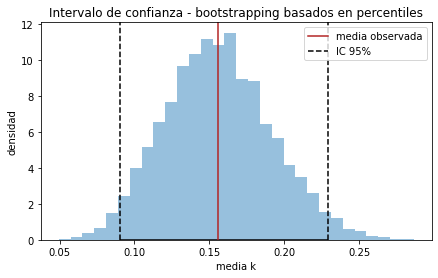

In [98]:
# Gráfico intervalo de confianza del 95%

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot_norte, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dist_boot_norte.mean(), color='firebrick', label='media observada')
ax.axvline(x=int_conf_norte_cuantiles[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=int_conf_norte_cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=int_conf_norte_cuantiles[0], xmax=int_conf_norte_cuantiles[1], color='black')
ax.set_title('Intervalo de confianza - bootstrapping basados en percentiles')
ax.set_xlabel('media k')
ax.set_ylabel('densidad')
ax.legend();

Grafico del intervalo de confianza del k del array: Paises_Norte_k

(array([2., 1., 0., 1., 1., 0., 1., 0., 0., 1.]),
 array([0.04761875, 0.07627185, 0.10492496, 0.13357806, 0.16223116,
        0.19088427, 0.21953737, 0.24819048, 0.27684358, 0.30549669,
        0.33414979]),
 <a list of 10 Patch objects>)

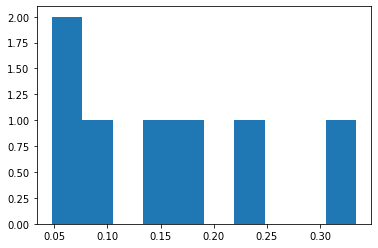

In [99]:
plt.hist(Paises_Norte_K)

In [100]:
#media y DS de la muestra experimental
mu_muestra_paises_norte = np.mean(Paises_Norte_K)
sigma_muestra_paises_norte = np.std(Paises_Norte_K)
print("Media de la muestra de los K de paises del norte (experimental): ", mu_muestra_paises_norte)
print("DS de la muestra de los K de paises del norte (experimental): ", sigma_muestra_paises_norte)

Media de la muestra de los K de paises del norte (experimental):  0.15583947167929763
DS de la muestra de los K de paises del norte (experimental):  0.09460666402712163


In [101]:
#media y DS del array de medias de k (btp)
mu_muestra_2_norte = np.mean(dist_boot_norte)
sigma_muestra_2_norte = np.std(dist_boot_norte)
print("Media de muestra bootstraping: ", mu_muestra_2_norte)
print("DS de muestra bootstraping: ", sigma_muestra_2_norte)

Media de muestra bootstraping:  0.1558859873019415
DS de muestra bootstraping:  0.03555356550837756


In [102]:
#Intervalo de confianza del array de k de paises del norte sin bootstraping

int_conf_norte_cuantiles_2 = np.quantile(a = Paises_Norte_K, q = [0.025, 0.975]) #le paso la distribucion de medias que le pase, y los quantiles

print('Intervalo de confianza: ', int_conf_norte_cuantiles_2,'(basado en cuantiles)' )
print('donde', int_conf_norte_cuantiles_2[0], 'es el límite inferior y ', int_conf_norte_cuantiles_2[1], 'es el límite superior' )

Intervalo de confianza:  [0.0481043 0.3174866] (basado en cuantiles)
donde 0.04810429567783881 es el límite inferior y  0.3174865994511028 es el límite superior


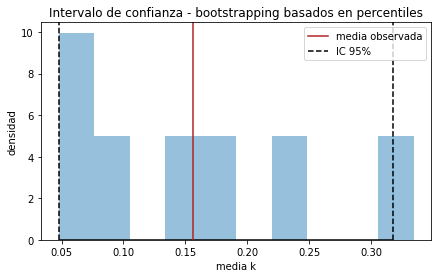

In [103]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(Paises_Norte_K, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=Paises_Norte_K.mean(), color='firebrick', label='media observada')
ax.axvline(x=int_conf_norte_cuantiles_2[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=int_conf_norte_cuantiles_2[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=int_conf_norte_cuantiles_2[0], xmax=int_conf_norte_cuantiles_2[1], color='black')
ax.set_title('Intervalo de confianza - bootstrapping basados en percentiles')
ax.set_xlabel('media k')
ax.set_ylabel('densidad')
ax.legend();

El k promedio de los paises elegidos sirve para representar a la poblacion mundial?

Para saberlo, se toma el k promedio de la misma cantidad de paises del sur, o aquellos que están en la estación del año contraria, y se compara.

Tambien se coteja con el K_world (datos mundiales)

Paises elegidos del sur: Argentina, Chile, Brasil, New Zealand, South Africa, Rwanda, Zimbabwe.

CHILE:

In [104]:
Chile = datos_covid[datos_covid.location.isin(["Chile"])]
Chile.head() #datos de Chile

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
36311,36414,Chile,CHL,2020-02-23,NaN,NaN,2.0,2.0
36312,36415,Chile,CHL,2020-02-24,NaN,NaN,2.0,0.0
36313,36416,Chile,CHL,2020-02-25,NaN,NaN,2.0,0.0
36314,36417,Chile,CHL,2020-02-26,NaN,NaN,2.0,0.0
36315,36418,Chile,CHL,2020-02-27,NaN,NaN,2.0,0.0


Text(0, 0.5, 'cantidad de casos')

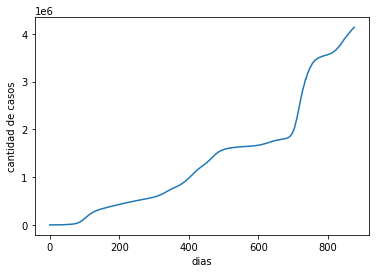

In [105]:
ind_Chile=np.where(paises=='Chile')
ind_Chile=ind_Chile[0]
casos_Chile=confirmados[ind_Chile]
casos_nuevos_Chile = casosnuevos[ind_Chile]
dias=np.arange(0,len(casos_Chile))
plt.plot(dias,casos_Chile)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

In [106]:
casos_principio_Chile=casos_Chile[0:60]
dias_principio_Chile=dias[0:60]

In [107]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio_Chile, casos_principio_Chile) 
popt, pcov


(array([ 7.19400093e-02, -7.34226992e+01]),
 array([[6.00195968e-06, 1.05100758e-02],
        [1.05100758e-02, 1.84594548e+01]]))

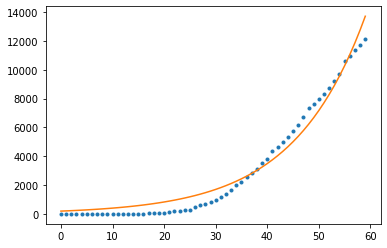

In [108]:
k_Chile=popt[0]
t0_Chile=popt[1]
casos_simu_Chile=exponencial(dias_principio_Chile,k_Chile,t0_Chile)
plt.plot(dias_principio_Chile,casos_principio_Chile,'.')
plt.plot(dias_principio_Chile,casos_simu_Chile)

In [109]:
k_Chile

0.07194000933140807

BRASIL:

In [110]:
Brasil = datos_covid[datos_covid.location.isin(["Brazil"])]
Brasil.head() #datos de Brasil

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
25087,25190,Brazil,BRA,2020-02-26,NaN,NaN,1.0,1.0
25088,25191,Brazil,BRA,2020-02-27,NaN,NaN,1.0,0.0
25089,25192,Brazil,BRA,2020-02-28,NaN,NaN,1.0,0.0
25090,25193,Brazil,BRA,2020-02-29,NaN,NaN,2.0,1.0
25091,25194,Brazil,BRA,2020-03-01,NaN,NaN,2.0,0.0


Text(0, 0.5, 'cantidad de casos')

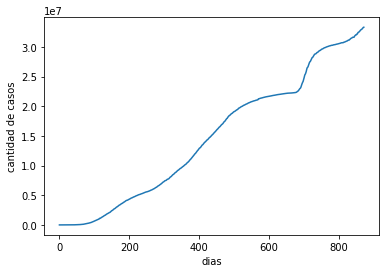

In [111]:
ind_Brasil=np.where(paises=='Brazil')
ind_Brasil=ind_Brasil[0]
casos_Brasil=confirmados[ind_Brasil]
casos_nuevos_Brasil = casosnuevos[ind_Brasil]
dias=np.arange(0,len(casos_Brasil))
plt.plot(dias,casos_Brasil)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

In [112]:
casos_principio_Brasil=casos_Brasil[0:60]
dias_principio_Brasil=dias[0:60]

In [113]:
popt, pcov = curve_fit(exponencial, dias_principio_Brasil, casos_principio_Brasil) 
popt, pcov

(array([  0.08453696, -71.38192348]), array([[3.04224676e-06, 4.49674215e-03],
        [4.49674215e-03, 6.66142625e+00]]))

In [114]:
k_Brasil=popt[0]
k_Brasil

0.08453696326844051

NUEVA ZELANDA:

In [115]:
Nueva_Zelanda = datos_covid[datos_covid.location.isin(["New Zealand"])]
Nueva_Zelanda.head() #datos de NZ

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
126652,129499,New Zealand,NZL,2020-02-28,NaN,NaN,1.0,1.0
126653,129500,New Zealand,NZL,2020-02-29,NaN,NaN,1.0,0.0
126654,129501,New Zealand,NZL,2020-03-01,225.0,NaN,1.0,0.0
126655,129502,New Zealand,NZL,2020-03-02,254.0,NaN,1.0,0.0
126656,129503,New Zealand,NZL,2020-03-03,280.0,NaN,1.0,0.0


In [116]:
ind_NZ=np.where(paises=='New Zealand')
ind_NZ=ind_NZ[0]
casos_NZ=confirmados[ind_NZ]

In [117]:
casos_principio_NZ=casos_NZ[0:60]
dias_principio_NZ=dias[0:60]

In [118]:
popt, pcov = curve_fit(exponencial, dias_principio_NZ, casos_principio_NZ) 
popt, pcov
k_NZ=popt[0]
k_NZ

0.04550722923192587

SUDAFRICA:

In [119]:
SA = datos_covid[datos_covid.location.isin(["South Africa"])]
SA.head() 

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
161038,167237,South Africa,ZAF,2020-03-05,NaN,NaN,1.0,1.0
161039,167238,South Africa,ZAF,2020-03-06,200.0,NaN,1.0,0.0
161040,167239,South Africa,ZAF,2020-03-07,241.0,NaN,1.0,0.0
161041,167240,South Africa,ZAF,2020-03-08,NaN,NaN,3.0,2.0
161042,167241,South Africa,ZAF,2020-03-09,NaN,NaN,3.0,0.0


In [120]:
ind_SA=np.where(paises=='South Africa')
ind_SA=ind_SA[0]
casos_SA=confirmados[ind_SA]

In [121]:
casos_principio_SA=casos_SA[0:60]
dias_principio_SA=dias[0:60]

In [122]:
popt, pcov = curve_fit(exponencial, dias_principio_SA, casos_principio_SA) 
popt, pcov
k_SA=popt[0]
k_SA

0.05584129608636385

RUANDA:

In [123]:
Ruanda = datos_covid[datos_covid.location.isin(["Rwanda"])]
Ruanda.head()

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
145374,151074,Rwanda,RWA,2020-03-14,NaN,NaN,1.0,1.0
145375,151075,Rwanda,RWA,2020-03-15,NaN,NaN,1.0,0.0
145376,151076,Rwanda,RWA,2020-03-16,NaN,NaN,5.0,4.0
145377,151077,Rwanda,RWA,2020-03-17,NaN,NaN,7.0,2.0
145378,151078,Rwanda,RWA,2020-03-18,NaN,NaN,8.0,1.0


In [124]:
ind_Ruanda=np.where(paises=='Rwanda')
ind_Ruanda=ind_Ruanda[0]
casos_Ruanda=confirmados[ind_Ruanda]

In [125]:
casos_principio_Ruanda=casos_Ruanda[0:60]
dias_principio_Ruanda=dias[0:60]

In [126]:
popt, pcov = curve_fit(exponencial, dias_principio_Ruanda, casos_principio_Ruanda) 
popt, pcov
k_Ruanda=popt[0]
k_Ruanda

0.035975147012443906

ZIMBABWE:

In [127]:
Zimbabwe = datos_covid[datos_covid.location.isin(["Zimbabwe"])]
Zimbabwe.head()

,index,location,iso_code,date,total_tests,total_deaths,total_cases,new_cases
193041,201110,Zimbabwe,ZWE,2020-03-20,NaN,NaN,1.0,1.0
193042,201111,Zimbabwe,ZWE,2020-03-21,NaN,NaN,3.0,2.0
193043,201112,Zimbabwe,ZWE,2020-03-22,NaN,NaN,3.0,0.0
193044,201113,Zimbabwe,ZWE,2020-03-23,NaN,1.0,3.0,0.0
193045,201114,Zimbabwe,ZWE,2020-03-24,NaN,1.0,3.0,0.0


In [128]:
ind_Zimbabwe=np.where(paises=='Zimbabwe')
ind_Zimbabwe=ind_Zimbabwe[0]
casos_Zimbabwe=confirmados[ind_Zimbabwe]

In [129]:
casos_principio_Zimbabwe=casos_Zimbabwe[0:60]
dias_principio_Zimbabwe=dias[0:60]

In [130]:
popt, pcov = curve_fit(exponencial, dias_principio_Zimbabwe, casos_principio_Zimbabwe) 
popt, pcov
k_Zimbabwe=popt[0]
k_Zimbabwe

0.030355299680010817

Paises del Sur:


In [131]:
Paises_Sur_K = array([k_arg, k_Chile, k_Brasil, k_NZ, k_SA, k_Ruanda, k_Zimbabwe])
Paises_Sur_K

array([0.04535294, 0.07194001, 0.08453696, 0.04550723, 0.0558413 ,
       0.03597515, 0.0303553 ])

In [132]:
dist_boot_sur = bootstraping(
                x = Paises_Sur_K,
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999)

**Grafico paises norte**

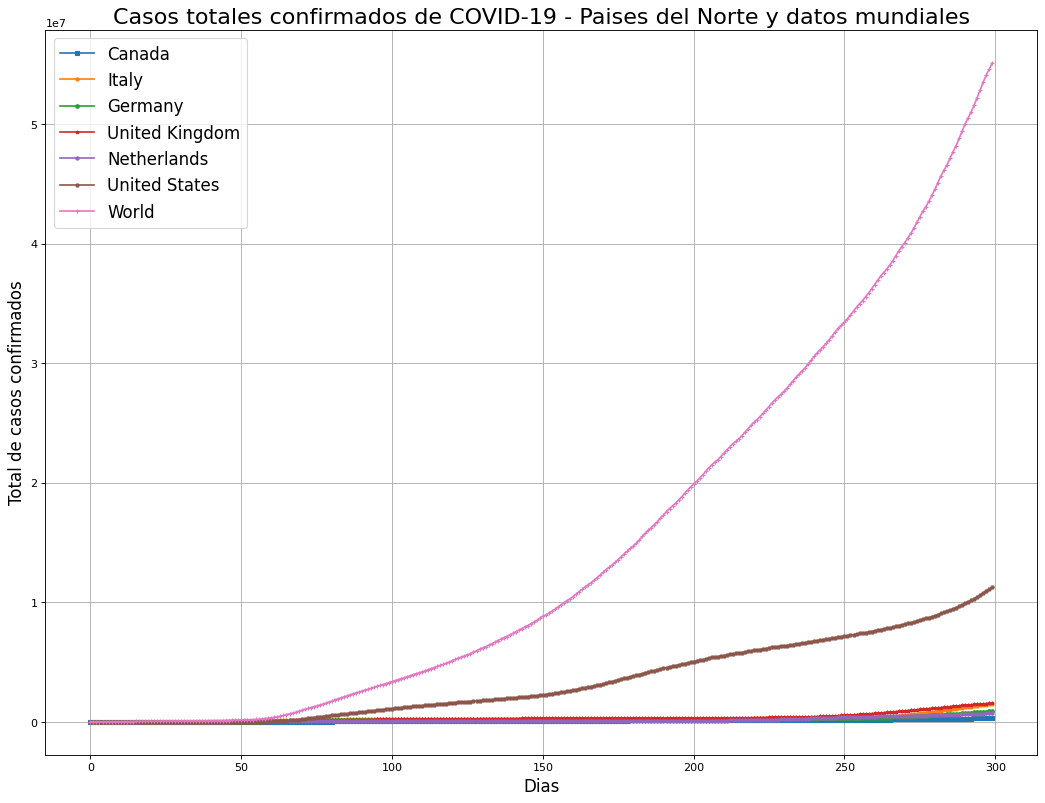

In [133]:
paises_n = ['Canada','Italy', 'Germany', 'United Kingdom', 'Netherlands','United States', "World"]
data_select = datos_covid[(datos_covid['location'].isin(paises_n))]

i = 0
scale = 2
plt.figure(figsize=(8*scale, 6*scale), dpi=80)
marks = ["s","p","o","*","h","H","+"]

for pais in paises_n:
   casos_pais = data_select['total_cases'][(data_select.location == pais)][0:300]
   dias = np.arange(casos_pais.shape[0]) 
   plt.plot(dias,casos_pais,label = pais, marker = marks[i], markersize = 3.2)
   i = i + 1

plt.title('Casos totales confirmados de COVID-19 - Paises del Norte y datos mundiales', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)   
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total de casos confirmados', fontsize = 15)
plt.xlabel('Dias', fontsize = 15)
plt.grid()
plt.show()

En estos graficos se ve que el crecimiento (primeros 300 dias) de la curva correspodiente a lo datos mundiales esta por encima del resto de los paises del mundo, de forma notoria, seguido por EEUU (en el segundo gráfico se ve mas claramente la diferencia de este ultimo con el resto de los paises)

**Graficos paises sur**

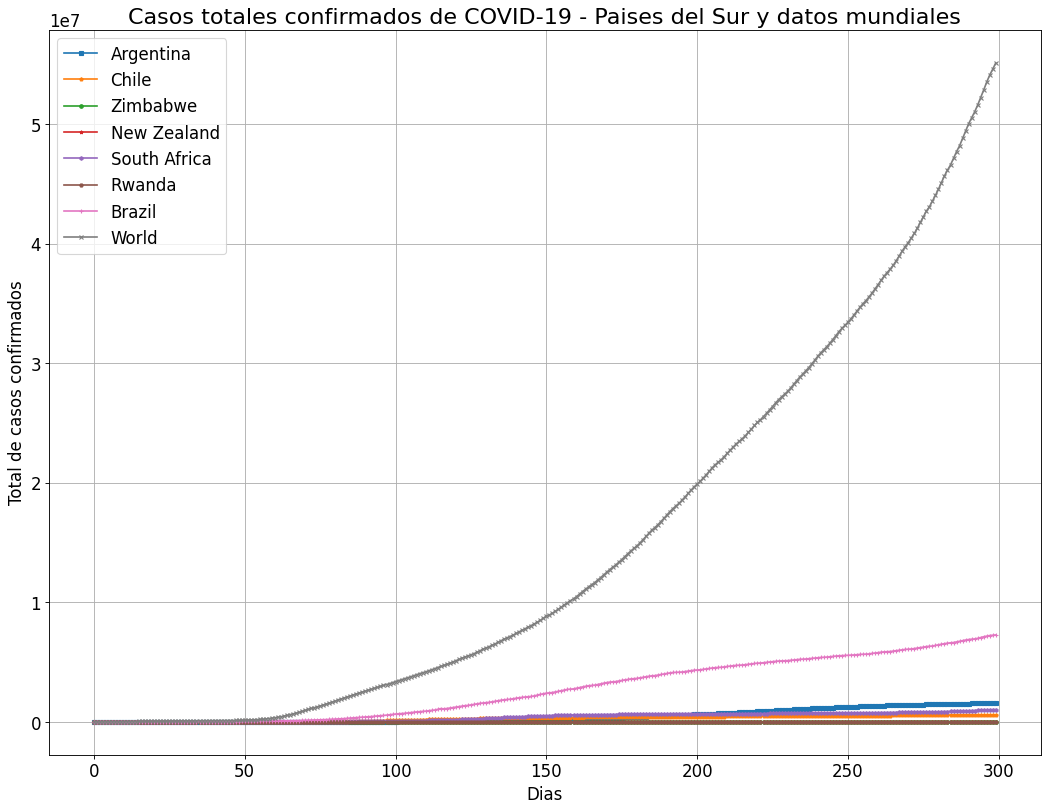

In [134]:
paises = ['Argentina', 'Chile', 'Zimbabwe', 'New Zealand', 'South Africa', 'Rwanda','Brazil', 'World']
data_2_select = datos_covid[(datos_covid['location'].isin(paises))]
#data_2_world  = data_2[(data_2['Entity'].isin(['World']))]

i = 0
scale = 2
plt.figure(figsize=(8*scale, 6*scale), dpi=80)
marks = ["s","p","o","*","h","H","+","x"]

for pais in paises:
   casos_pais = data_2_select['total_cases'][(data_2_select.location == pais)][0:300]
   dias = np.arange(casos_pais.shape[0]) 
   plt.plot(dias,casos_pais,label = pais, marker = marks[i], markersize = 3.2)
   i = i + 1

plt.title('Casos totales confirmados de COVID-19 - Paises del Sur y datos mundiales', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total de casos confirmados', fontsize = 15)
plt.xlabel('Dias', fontsize = 15)
plt.grid()
plt.show()

La tendencia se repite en cuanto a los paises del sur en relacion con los datos mundiales.

**Grafico mundo**

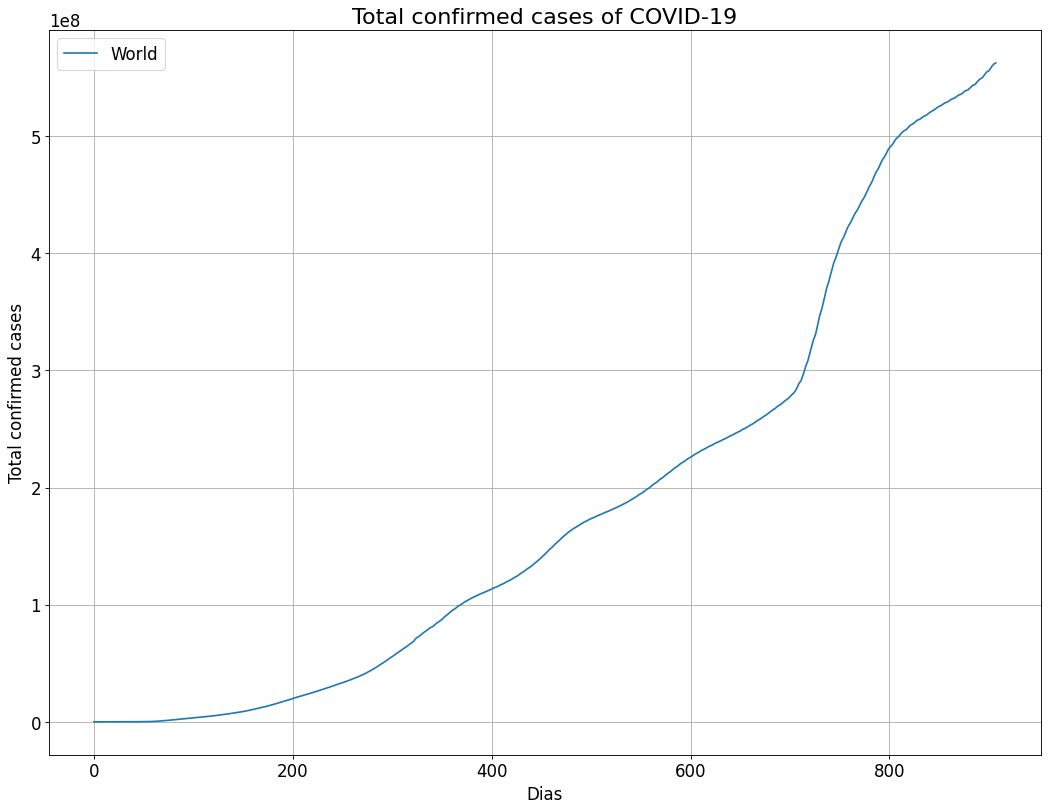

In [135]:
datos_world  = datos_covid[(datos_covid['location'].isin(['World']))]

casos_world = datos_world['total_cases']
dias = np.arange(casos_world.shape[0]) 

plt.figure(figsize=(8*scale, 6*scale), dpi=80)
plt.plot(dias,casos_world, label = 'World')
plt.title('Total confirmed cases of COVID-19', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total confirmed cases', fontsize = 15)
plt.xlabel('Dias', fontsize = 15)
plt.grid()
plt.show()

INTERVALOS CONFIANZA: SUR.

In [136]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975, porque la suma de los errores da 0.5 (lo que falta de 95 para llegar a 100%)
int_conf_cuantiles_sur = np.quantile(a = dist_boot_sur, q = [0.025, 0.975]) #le paso la distribucion de medias que le pase, y los quantiles

print('Intervalo de confianza: ', int_conf_cuantiles_sur,'(basado en cuantiles)' )
print('donde', int_conf_cuantiles_sur[0], 'es el límite inferior y ', int_conf_cuantiles_sur[1], 'es el límite superior' )

Intervalo de confianza:  [0.04044576 0.06640523] (basado en cuantiles)
donde 0.04044575890285309 es el límite inferior y  0.06640522890148719 es el límite superior


INTERVALOS CONFIANZA: NORTE.

In [137]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975, porque la suma de los errores da 0.5 (lo que falta de 95 para llegar a 100%)
cuantiles = np.quantile(a = dist_boot_norte, q = [0.025, 0.975]) #le paso la distribucion de medias que le pase, y los quantiles

print('Intervalo de confianza: ', cuantiles,'(basado en cuantiles)' )
print('donde', cuantiles[0], 'es el límite inferior y ', cuantiles[1], 'es el límite superior' )

Intervalo de confianza:  [0.09028857 0.22952641] (basado en cuantiles)
donde 0.0902885669302713 es el límite inferior y  0.22952640833967114 es el límite superior


A simple vista, no habria evidencia estadística de que el promedio de K de los paises del norte es representativo de los paises del sur

In [138]:
#media y DS de la muestra experimental
mu_muestra_paises_sur = np.mean(Paises_Sur_K)
sigma_muestra_paises_sur = np.std(Paises_Sur_K)
print("Media de la muestra de los K de paises del sur (experimental): ", mu_muestra_paises_sur)
print("DS de la muestra de los K de paises del sur (experimental): ", sigma_muestra_paises_sur)

Media de la muestra de los K de paises del sur (experimental):  0.05278698408448825
DS de la muestra de los K de paises del sur (experimental):  0.018040852411088226


In [139]:
#media y DS de la muestra bootstraping
mu_muestra_paises_sur_2 = np.mean(dist_boot_sur)
sigma_muestra_paises_sur_2 = np.std(dist_boot_sur)
print("Media de la muestra de los K de paises del sur (bootstraping): ", mu_muestra_paises_sur_2)
print("DS de la muestra de los K de paises del sur (bootstraping): ", sigma_muestra_paises_sur_2)

Media de la muestra de los K de paises del sur (bootstraping):  0.052803356862387275
DS de la muestra de los K de paises del sur (bootstraping):  0.006767373454771723


In [140]:
mu_muestra_paises_norte, mu_muestra_paises_sur

(0.15583947167929763, 0.05278698408448825)

In [141]:
mu_muestra_2_norte, mu_muestra_paises_sur_2

(0.1558859873019415, 0.052803356862387275)

El promedio de k de los paises del norte y del sur difieren . Veamos con un test de hipótesis si el promedio de k de los paises del norte es representativo del resto de los paises

H1 = Las medias de ambos son similares, lo que arroja que la media de los k de los paises del norte es representativa

H0 = Las medias no son similares, lo que arroja que la media de los k de los paises del norte no es representativa

In [142]:
import numpy as np
import pandas as pd
from scipy.stats import t
import scipy 

 
def mean_difference(data1, data2, alpha): # Función: utilice el nivel de significancia de alfa para comprobar si existe una diferencia significativa entre las dos medias de población
#la funcion recibe estos datos = muestra 1 y 2 (a comprara) y el nivel de significancia (alpha)
    
    n1 = len(data1)
    n2 = len(data2)
    
    x1_mean = np.mean(data1)
    x2_mean = np.mean(data2)
    
    x1_var = np.var(data1, ddof=1) 
    x2_var = np.var(data2, ddof=1) 
    
         # f grados de libertad
    f = np.power((x1_var/n1 + x2_var/n2), 2) / ((np.power((x1_var/n1), 2)/(n1-1)) + (np.power((x2_var/n2), 2)/(n2-1)))
    t_score = scipy.stats.t.isf (alpha, df = int (f)) # valor crítico de la distribución t
         # Prueba estadística t valor
    t_value = ((x1_mean - x2_mean)-(0)) / np.sqrt((x1_var/n1) + (x2_var/n2))
    
    if abs(t_value) > abs(t_score):
        result = 'Acepta H1, rechaza H0'
    else:
        result = 'Acepta H0, rechaza H1'
        
    return t_score, t_value ,result #devuelve el t_score, t_value y el resultado según las hipotesis planteadas


print(mean_difference(dist_boot_norte, dist_boot_sur, 0.05))

(1.6449957686943504, 284.79392339331355, 'Acepta H1, rechaza H0')


OTRA MANERA DE HACER PRUEBA DE HIPÓTESIS (T-Value)

In [143]:
n_dist_boot_norte = len(dist_boot_norte)
media_dist_boot_norte = dist_boot_norte.mean()
std_dist_boot_norte = dist_boot_norte.std()
print('Remuestreo = K Paises del Norte')
print('N (tamaño): ', n_dist_boot_norte)
print('Media: ', media_dist_boot_norte)
print('Desviación estándar: ', std_dist_boot_norte)
print()
n_dist_boot_sur = len(dist_boot_sur)
media_dist_boot_sur = dist_boot_sur.mean()
std_dist_boot_sur = dist_boot_sur.std()
print('Remuestreo = K Paises del Sur')
print('N (tamaño): ', n_dist_boot_sur)
print('Media: ', media_dist_boot_sur)
print('Desviación estándar: ', std_dist_boot_sur)

Remuestreo = K Paises del Norte
N (tamaño):  9999
Media:  0.1558859873019415
Desviación estándar:  0.03555356550837756

Remuestreo = K Paises del Sur
N (tamaño):  9999
Media:  0.052803356862387275
Desviación estándar:  0.006767373454771723


In [144]:
# HIPOTESIS
#H0 = Las medias de ambos son similares, lo que arroja que existe evidencia estadística de que la media de los k de los paises del norte es representativa
#H1 = Las medias no son similares, lo que arroja que no existe evidencia estadística de que la media de los k de los paises del norte es representativa

alpha = 0.05
confianza = 1 - alpha

In [145]:
from scipy import stats
import math

In [146]:
norte = std_dist_boot_norte / math.sqrt(n_dist_boot_norte) * stats.t.ppf((1 + confianza) / 2, n_dist_boot_norte - 1)

In [147]:
sur = std_dist_boot_sur / math.sqrt(n_dist_boot_sur) * stats.t.ppf((1 + confianza) / 2, n_dist_boot_sur - 1)

In [148]:
print('Intervalo de Confianza - Norte: ', media_dist_boot_norte - norte, media_dist_boot_norte + norte)
print('Intervalo de Confianza - Sur: ', media_dist_boot_sur - sur, media_dist_boot_sur + sur)

Intervalo de Confianza - Norte:  0.1551890310044589 0.1565829435994241
Intervalo de Confianza - Sur:  0.05267069608760202 0.05293601763717253


In [149]:
tprueba, pvalue = stats.ttest_ind(dist_boot_norte, dist_boot_sur, equal_var = False)

In [150]:
print('p-value = ', pvalue)

p-value =  0.0


In [151]:
if pvalue >= alpha: 
    print('Las medias de ambos son similares (acepta H0)') 
else: 
    print('Las medias no son similares (rechaza H0)')

Las medias no son similares (rechaza H0)


**SEGUNDA PARTE:**

Evaluando estrategias. 

In [152]:
## países con y sin cuarentena:
#no = 0
#si = 1


no = ['Mexico','Sweden','India','Bolivia','Brazil','Uruguay','Netherlands', 'United Kingdom']
si = ['Argentina','China', 'Portugal','Spain', 'Chile', 'Italy','France','Australia' ]
paises_elegidos = ['Mexico','Sweden','India','Bolivia','Brazil','Uruguay','Netherlands', 'United Kingdom','Argentina','China', 'Portugal','Spain', 'Chile', 'Italy','France','Australia']
cuarentena = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]

In [153]:
# Se genera un DF vacío con todos los países seleccionados:
datos = {'Pais': paises_elegidos, 'k_muertes': np.zeros(len(paises_elegidos)), 'k_contagios': np.zeros(len(paises_elegidos)), 'muertes/casos': np.zeros(len(paises_elegidos)),'target': cuarentena}  
Covid= pd.DataFrame(datos)
Covid

,Pais,k_muertes,k_contagios,muertes/casos,target
0,Mexico,0.0,0.0,0.0,0
1,Sweden,0.0,0.0,0.0,0
2,India,0.0,0.0,0.0,0
3,Bolivia,0.0,0.0,0.0,0
4,Brazil,0.0,0.0,0.0,0
5,Uruguay,0.0,0.0,0.0,0
6,Netherlands,0.0,0.0,0.0,0
7,United Kingdom,0.0,0.0,0.0,0
8,Argentina,0.0,0.0,0.0,1
9,China,0.0,0.0,0.0,1


In [154]:
df_covid = pd.DataFrame({'Paises': ['Mexico','Sweden','India','Bolivia','Brazil','Uruguay','Netherlands', 'United Kingdom','Argentina','China', 'Portugal','Spain', 
                                    'Chile', 'Italy','France','Australia'],
                         'Cuarentena': ['No','No','No','No','No','No','No','No','Si','Si','Si','Si','Si','Si','Si','Si']})


df_covid = df_covid.sample(frac=True).reset_index(drop=True)
df_covid

,Paises,Cuarentena
0,Chile,Si
1,Netherlands,No
2,Mexico,No
3,Bolivia,No
4,China,Si
5,Uruguay,No
6,Spain,Si
7,Italy,Si
8,United Kingdom,No
9,Argentina,Si


In [158]:
# Cálculo de las k:
# Las voy a calcular en función de los datos de:
cases = 'total_cases'
deaths = 'total_deaths'

In [159]:
## países con y sin cuarentena:
#no = 0
#si = 1
no = ['Mexico','Sweden','India','Bolivia','Brazil','Uruguay','Netherlands', 'United Kingdom']
si = ['Argentina','China', 'Portugal','Spain', 'Chile', 'Italy','France','Australia' ]
paises_elegidos = ['Mexico','Sweden','India','Bolivia','Brazil','Uruguay','Netherlands', 'United Kingdom','Argentina','China', 'Portugal','Spain', 'Chile', 'Italy','France','Australia']
cuarentena = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]

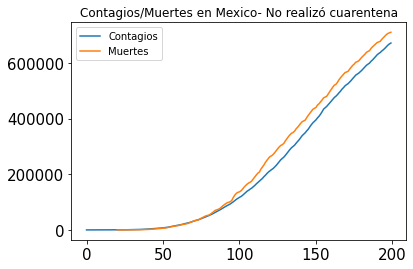

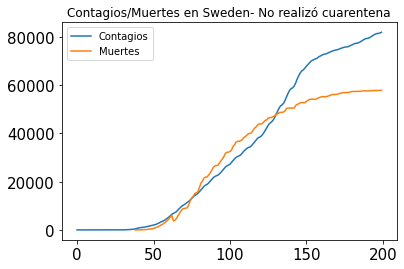

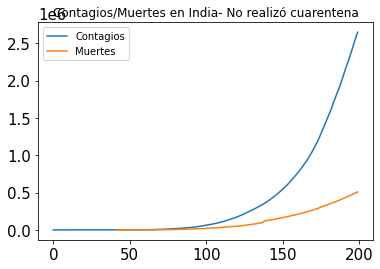

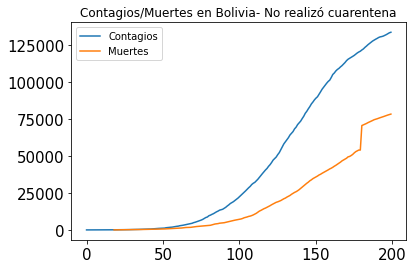

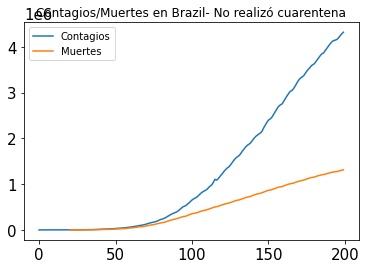

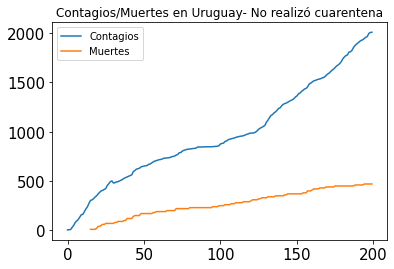

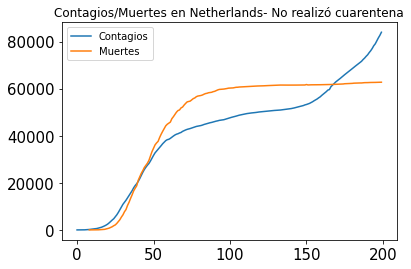

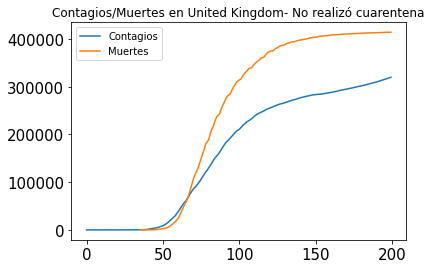

In [160]:
#Paises que NO realizaron cuarentena estricta desde el principio
i = 0
paises = no
for pais in paises:
  casos_pais = datos_covid['total_cases'][(datos_covid.location == pais)][0:200]
  muertes_pais = datos_covid['total_deaths'][(datos_covid.location == pais)][0:200]
  dias = np.arange(casos_pais.shape[0]) 
  plt.figure(i)
  plt.plot(dias,casos_pais,label = 'Contagios')
  plt.title(' Casos en '+ pais)
  plt.legend()

  plt.figure(i)
  plt.plot(dias,muertes_pais*10,label = 'Muertes')
  plt.title('Contagios/Muertes en '+ pais + '- No realizó cuarentena')
  plt.legend()
  plt.show()
  i = i + 1

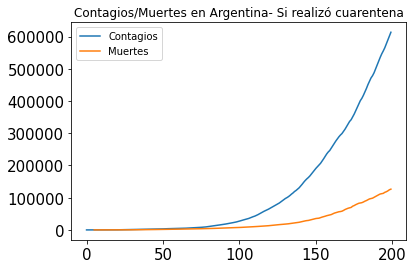

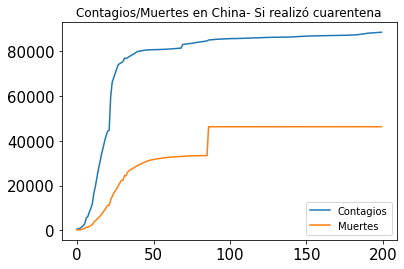

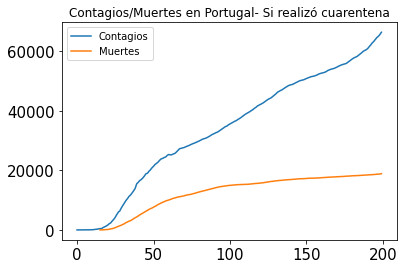

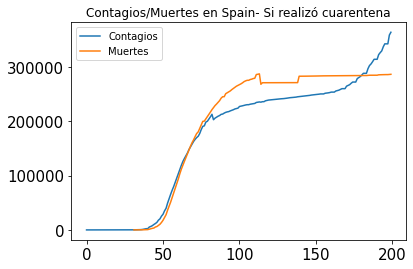

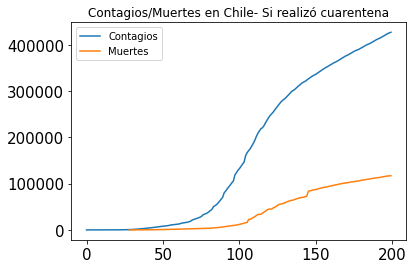

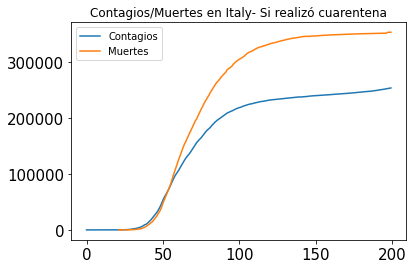

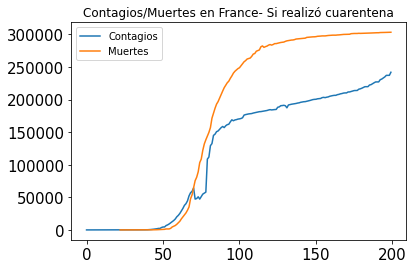

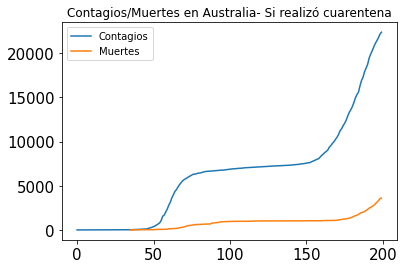

In [161]:
#Paises que realizaron cuarentena estricta desde el principio
i = 0
paises = si
for pais in paises:
  casos_pais = datos_covid['total_cases'][(datos_covid.location == pais)][0:200]
  muertes_pais = datos_covid['total_deaths'][(datos_covid.location == pais)][0:200]
  dias = np.arange(casos_pais.shape[0]) 
  plt.figure(i)
  plt.plot(dias,casos_pais,label = 'Contagios')
  plt.title(' Casos en '+ pais)
  plt.legend()

  plt.figure(i)
  plt.plot(dias,muertes_pais*10,label = 'Muertes')
  plt.title('Contagios/Muertes en '+ pais + '- Si realizó cuarentena')
  plt.legend()
  plt.show()
  i = i + 1

In [162]:
#Se calcula el k.
# Uso un fiteo por cuadrados mínimos exponencial:
# Lo hago para todos los países.

#no = ['Mexico','Sweden','India','Bolivia','Brazil','Uruguay','Netherlands', 'United Kingdom']
#si = ['Argentina','China', 'Portugal','Spain', 'Chile', 'Italy','France','Australia' ]
paises_elegidos = ['Mexico','Sweden','India','Bolivia','Brazil','Uruguay','Netherlands', 'United Kingdom','Argentina','China', 'Portugal','Spain', 'Chile', 'Italy','France','Australia']
#cuarentena = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]
#cases = 'Total_confirmed_cases_of_Covid19'
#deaths = 'Total_confirmed_death_due_to_Covid19'

paises = paises_elegidos
i = 0
for pais in paises:
    casos_pais = datos_covid['total_cases'][(datos_covid.location == pais)][200:401]
    muertes_pais = datos_covid['total_deaths'][(datos_covid.location == pais)][200:401]
    muertes_casos = np.mean(muertes_pais)/np.mean(casos_pais)
    dias = np.arange(200,401) 
    popt_casos , pcov_casos  = curve_fit(exponencial, dias, casos_pais, maxfev = 2000)       # Fiteo las exponenciales de casos.
    popt_muertes , pcov_muertes  = curve_fit(exponencial, dias, muertes_pais, maxfev = 2000)     # Fiteo las exponenciales de muertes.
    # Inserto los datos al df que voy a usar para hacer el modelo:
    Covid.loc[i,('k_contagios')]          =  popt_casos[0]
    Covid.loc[i,('k_muertes')]       =  popt_muertes[0]
    Covid.loc[i,('muertes/casos')] =  muertes_casos
    i = i + 1

In [163]:
Covid

,Pais,k_muertes,k_contagios,muertes/casos,target
0,Mexico,0.994225,0.991400,0.091402,0
1,Sweden,0.992600,0.992887,0.026440,0
2,India,0.987894,0.994201,0.014834,0
3,Bolivia,0.992893,0.991957,0.052206,0
4,Brazil,0.991039,0.993435,0.025969,0
5,Uruguay,0.992944,0.988163,0.010335,0
6,Netherlands,0.990580,0.995088,0.016084,0
7,United Kingdom,0.990454,0.994059,0.035696,0
8,Argentina,0.988220,0.990801,0.025466,1
9,China,0.992815,0.992452,0.049982,1


Data final:

In [164]:
Covid = Covid.sample(frac=True).reset_index(drop=True) #reindexo de forma aleatoria.
Covid

,Pais,k_muertes,k_contagios,muertes/casos,target
0,Portugal,0.990393,0.991414,0.018684,1
1,Australia,0.989611,0.993921,0.030997,1
2,Italy,0.992385,0.988569,0.041459,1
3,United Kingdom,0.990454,0.994059,0.035696,0
4,Mexico,0.994225,0.991400,0.091402,0
5,China,0.992815,0.992452,0.049982,1
6,Bolivia,0.992893,0.991957,0.052206,0
7,France,0.993404,0.994752,0.027604,1
8,Brazil,0.991039,0.993435,0.025969,0
9,Uruguay,0.992944,0.988163,0.010335,0


Modelo de clasificación: Regresión Logística.
Como benchmark usaremos un accuracy del 50%. 

In [165]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
## Importo los modelos que voy a usar/probar:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
## Librerías de optimización de modelos:
from sklearn.model_selection import RandomizedSearchCV

In [166]:
Covid.columns

Index(['Pais', 'k_muertes', 'k_contagios', 'muertes/casos', 'target'], dtype='object')

In [167]:
## #establcemos X e y:
X = Covid[['k_muertes','k_contagios','muertes/casos']]
y = Covid[['target']] # Paises que hicieron cuarentena: 1, Paises que no hicieron cuarentena: 0.

## Separo en train y test:

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [168]:
RL = LogisticRegression()
RL.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [170]:
def Matriz_de_confusion(y_test,y_pred):
    names=["0","1"]
    cm=confusion_matrix(y_test,y_pred,normalize='true')
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",ax=ax) #fmt=".0f",
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

Regresion Logística


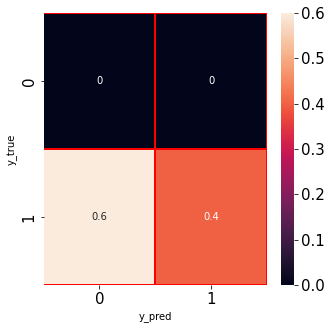

acc :  0.4
F1 Score:  0.28571428571428575
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [171]:
#Regresión Logistica:
#-----------------------
print('Regresion Logística')
y_pred_RL = RL.predict(x_test)
Matriz_de_confusion(y_pred_RL,y_test)

print("acc : ",accuracy_score(y_test, y_pred_RL))
print("F1 Score: ", f1_score(y_test ,y_pred_RL, average='macro'))
print(classification_report(y_test, y_pred_RL))

In [172]:
## Naive Bayes:

NB = GaussianNB() # Benchmark para comparar contra Linear SVC y XGboost.
NB.fit(x_train,np.array(y_train).ravel())

GaussianNB()

Gaussian Naive Bayes


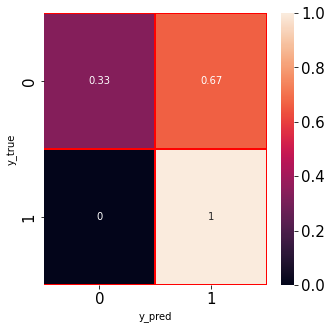

acc :  0.6
F1 Score:  0.5833333333333333
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.50      1.00      0.67         2

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5



In [173]:
print('Gaussian Naive Bayes')
y_pred_NB = NB.predict(x_test)
Matriz_de_confusion(y_test,y_pred_NB)

print("acc : ",accuracy_score(y_test, y_pred_NB))
print("F1 Score: ", f1_score(y_test ,y_pred_NB, average='macro'))
print(classification_report(y_test, y_pred_NB))

1.Pruebas:
La Organización Mundial para la Salud (OMS) y los expertos consultados por BBC Mundo coinciden en que la detección temprana de los casos es un factor fundamental para contener la extensión de la pandemia.
No se pueden tomar acciones ni conocer el impacto real del virus si no sabemos a cuántas personas ha afectado.

En la Universidad de Temple (EE.UU.), coincide en que este factor ha marcado la diferencia entre algunas naciones que están mostrando mejores resultados en su batalla contra el virus y otras donde el número de casos aumenta rápidamente. El director de la OMS, consideró que facilitar las pruebas a cualquier persona con síntomas de haberse contagiado era la "columna vertebral para detener la propagación" de la pandemia.

Sin embargo, alertó que muchos gobiernos continúan haciendo los exámenes solo a los pacientes más graves, lo que no solo puede falsear las estadística sino propiciar que personas con síntomas más leves continúen propagando el virus.

2.Aislar a los contagiados. La realización de pruebas permite no solo aislar a los enfermos y evitar que se propague el virus entre un mayor número de personas, sino que también abre la posibilidad para detectar posibles contagios que todavía no han desarrollado síntomas.


3.Preparación y reacción rápida De acuerdo con Nyenswah, quien fue uno de los responsables del combate al ébola en África Occidental, uno de los elementos básicos para la contención de un virus es reaccionar rápidamente antes que los contagios se diseminen por la población.


4.Distanciamiento social. Cuando se reportan los primeros contagios de un nuevo virus en una población, las medidas de contención dejan de tener sentido y otras, como el distanciamiento social, resultan ser más efectivas para evitar que los sectores más vulnerables se contagien.